In [ ]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [386]:
# hyperparameter tuning flag
HYPERPARAMETER_TUNING = False

# load cleaned datasets
cleaned_datasets_path = os.path.abspath(os.path.join('cleaned_datasets'))

def load_dataset(filename):
    file_path = os.path.join(cleaned_datasets_path, filename)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    return pd.read_csv(file_path)

df_sale = load_dataset('rumah123_2025_sale_properties_cleaned.csv')
df_rent = load_dataset('rumah123_2025_rent_properties_cleaned.csv')
df_sale_2023 = load_dataset('rumah123_2023_sale_properties_cleaned.csv')

## MODELLING

### 2023 Property Sale Price Prediction Model

In [387]:
X = df_sale_2023.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_encoded = pd.get_dummies(X, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y = df_sale_2023['price_in_rp'].copy()

In [388]:
# Prepare the dataset for sale properties in 2023. We want to make sure the 2023_sale dataset have the same OHE features as the 2025_sale dataset.
df_sale_2025 = df_sale.copy()
X_sale_2025 = df_sale_2025.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_2025_encoded = pd.get_dummies(X_sale_2025, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

In [389]:
for i in X_encoded.columns:
    if i not in X_sale_2025_encoded.columns:
        X_sale_2025_encoded[i] = 0
    

for i in X_sale_2025_encoded.columns:
    if i not in X_encoded.columns:
        X_encoded[i] = 0
        
X_sale_2025_encoded = X_sale_2025_encoded[X_encoded.columns]

for i, val in enumerate(X_encoded.columns):
    if val != X_sale_2025_encoded.columns[i]:
        X_sale_2025_encoded.drop(val, axis=1, inplace=True)
        if X_sale_2025_encoded.shape[1] == X_encoded.shape[1]:
            break

X_sale_to_sale_2023 = X_sale_2025_encoded.copy()
print(X_sale_2025_encoded.shape, X_encoded.shape)

(1739, 294) (3166, 294)


C:\Users\balse\AppData\Local\Temp\ipykernel_1700\2740170810.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_sale_2025_encoded[i] = 0
C:\Users\balse\AppData\Local\Temp\ipykernel_1700\2740170810.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_sale_2025_encoded[i] = 0
C:\Users\balse\AppData\Local\Temp\ipykernel_1700\2740170810.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=42)

In [391]:
# Log-transform the target variable to reduce skewness and improve model performance
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [392]:
# Hyperparameter tuning
'''
- n_estimators
- learning_rate
- max_depth
- subsample
- colsample_bytree
- gamma
- lambda alpha
'''

if HYPERPARAMETER_TUNING:
    param_grid = {
        "n_estimators": [200, 500, 1000],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1],
    }

    grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

    grid_search.fit(X_train, y_train)

    grid_search.best_params_

In [393]:
sale_2023_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.01,
                            max_depth=7,
                            subsample=1.0,
                            colsample_bytree=0.8,
                            gamma=0,
                            random_state=42)
sale_2023_model.fit(X_train.to_numpy(), y_train.to_numpy())

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [394]:
# RMSE in log-scale
reg_xgb_pred = sale_2023_model.predict(X_test.to_numpy())  # in log-scale
rmse_log = np.sqrt(MSE(y_test, reg_xgb_pred))
print(rmse_log)

0.2697912549065918


In [344]:
# RMSE in rupiah
y_test_rp = np.expm1(y_test)
reg_xgb_pred_rp = np.expm1(reg_xgb_pred)

mse_rupiah = MSE(y_test_rp, reg_xgb_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
rmse_rupiah

np.float64(585932512.9438686)

In [345]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = sale_2023_model.predict(X_test.to_numpy())         # model outputs logₑ(price)
pred_price = np.expm1(pred_log)                     # back to actual Rupiah
print(pred_price)

[2.30472464e+08 3.17040224e+08 1.03553542e+09 8.39629632e+08
 1.19702682e+09 5.50211072e+08 1.25571584e+09 1.56368781e+09
 4.43378176e+09 7.82365696e+08 1.20599885e+09 1.95508160e+09
 2.99069414e+09 3.25433888e+08 4.82234419e+09 4.45963315e+09
 3.88112544e+08 5.33951552e+08 4.62893120e+08 5.11919776e+08
 1.67945549e+09 1.29770086e+09 3.51668096e+09 5.26851808e+08
 2.93293286e+09 9.78321856e+08 3.67853952e+09 5.48648576e+08
 3.43112256e+08 1.61459904e+09 1.83948288e+09 2.83186176e+09
 1.04855763e+09 3.50839840e+08 6.72058048e+08 1.43084851e+09
 1.22783731e+09 5.34148128e+08 1.51450035e+09 1.41190118e+09
 3.98484557e+09 7.04553984e+08 7.41319744e+08 8.60886272e+08
 2.62031309e+09 9.10014528e+08 2.13777267e+09 2.08960589e+09
 8.75451264e+08 1.09861491e+09 5.45395661e+09 1.26853709e+09
 1.27448614e+09 4.82428256e+08 3.62565581e+09 1.29407245e+09
 9.92534784e+08 5.41283200e+08 5.66785152e+08 1.48140493e+09
 1.38563610e+09 3.22540800e+09 1.18983386e+09 8.85294464e+08
 7.56620352e+08 1.837575

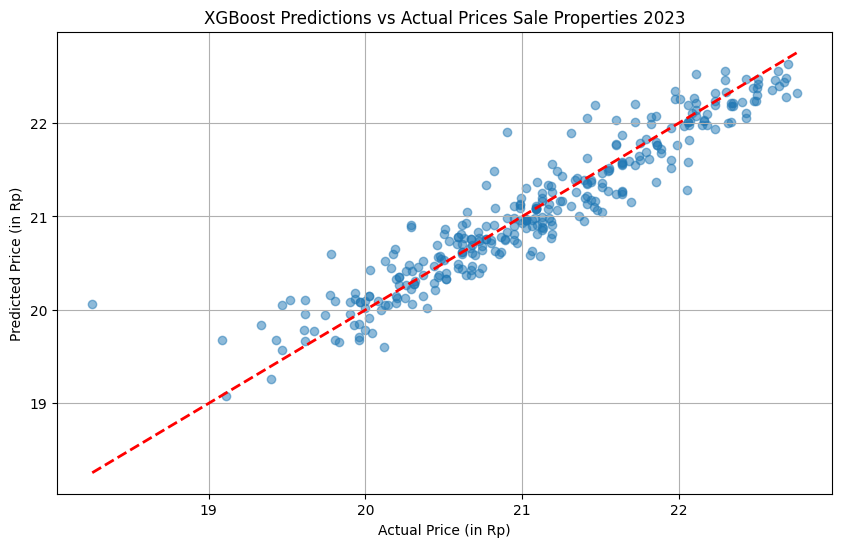

In [346]:
# visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, reg_xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual Prices Sale Properties 2023')
plt.grid()
plt.show()

### 2025 Property Rent Price Prediction Model

In [347]:
X_rent = df_rent.drop(['rent_price_per_year', 'url', 'title', 'description'], axis=1).copy()
X_rent_encoded = pd.get_dummies(X_rent, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y_rent = df_rent['rent_price_per_year'].copy()

In [348]:
# Prepare the dataset for rent properties in 2025. We want to make sure the 2023_sale dataset have the same OHE features as the 2025_rent dataset.
df_sale_2025 = df_sale.copy()
X_sale_2025 = df_sale_2025.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_2025_encoded = pd.get_dummies(X_sale_2025, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

In [349]:
X_rent_encoded = X_rent_encoded.loc[:, ~X_rent_encoded.columns.duplicated()]
X_sale_2025_encoded = X_sale_2025_encoded.loc[:, ~X_sale_2025_encoded.columns.duplicated()]

all_columns = sorted(set(X_rent_encoded.columns).union(X_sale_2025_encoded.columns))

X_rent_encoded = X_rent_encoded.reindex(columns=all_columns, fill_value=0)
X_sale_2025_encoded = X_sale_2025_encoded.reindex(columns=all_columns, fill_value=0)
        
X_sale_2025_encoded = X_sale_2025_encoded[X_rent_encoded.columns]

for i, val in enumerate(X_rent_encoded.columns):
    if val != X_sale_2025_encoded.columns[i]:
        X_sale_2025_encoded.drop(val, axis=1, inplace=True)
        if X_sale_2025_encoded.shape[1] == X_rent_encoded.shape[1]:
            break

print(X_sale_2025_encoded.shape, X_rent_encoded.shape)

X_rent_to_sale_2025 = X_sale_2025_encoded.copy()

(1739, 952) (7245, 952)


In [350]:
X_rent_train, X_rent_test, y_rent_train, y_rent_test = train_test_split(X_rent_encoded, y_rent, test_size=0.2, random_state=42)

In [351]:
# Log-transform the target variable to reduce skewness and improve model performance
y_rent_train = np.log1p(y_rent_train)
y_rent_test = np.log1p(y_rent_test)

In [352]:
# Hyperparameter tuning
'''
- n_estimators
- learning_rate
- max_depth
- subsample
- colsample_bytree
- gamma
- lambda alpha
'''

if HYPERPARAMETER_TUNING:
    param_grid = {
        "n_estimators": [200, 500, 1000],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7, 9],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1],
    }

    grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

    grid_search.fit(X_rent_train, y_rent_train)

    print("Best Parameters:", grid_search.best_params_)

In [353]:
rent_2025_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.1,
                            max_depth=5,
                            subsample=1.0,
                            colsample_bytree=0.6,
                            gamma=0,
                            random_state=42)
rent_2025_model.fit(X_rent_train.to_numpy(), y_rent_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [354]:
# rmse in log-scale
rent_2025_pred = rent_2025_model.predict(X_rent_test.to_numpy())
rmse_log = np.sqrt(MSE(y_rent_test, rent_2025_pred))
print(rmse_log)

0.34341097706744145


In [355]:
# rmse in rupiah
y_rent_test_rp = np.expm1(y_rent_test)
rent_2025_pred_rp = np.expm1(rent_2025_pred)
mse_rupiah = MSE(y_rent_test_rp, rent_2025_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
print(rmse_rupiah)

51323929.01518579


In [356]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = rent_2025_model.predict(X_rent_test.to_numpy())  # model outputs logₑ(price)
pred_price = np.expm1(pred_log)  # back to actual Rupiah
print(pred_price)

[3.5220272e+07 6.3499176e+07 5.7967712e+07 ... 1.0980759e+08 6.9302488e+07
 5.0941340e+07]


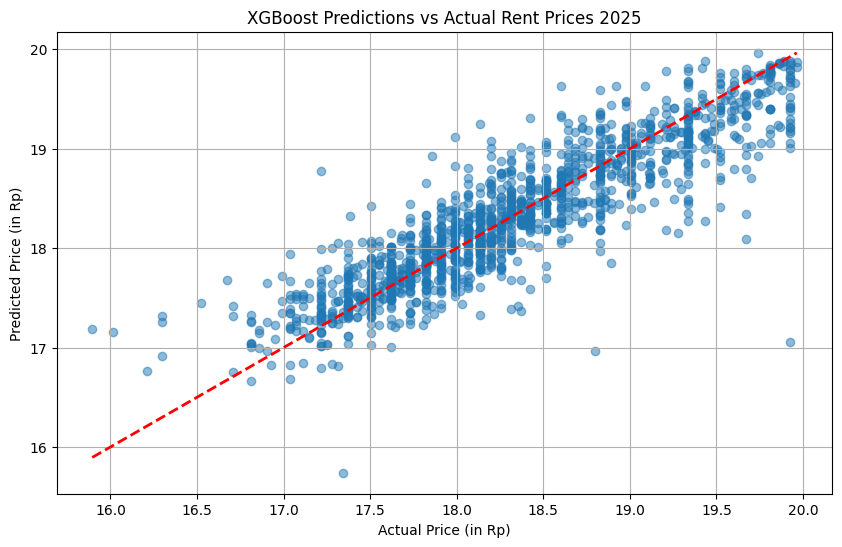

In [357]:
# visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_rent_test, rent_2025_pred, alpha=0.5)
plt.plot([y_rent_test.min(), y_rent_test.max()], [y_rent_test.min(), y_rent_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual Rent Prices 2025')
plt.grid()
plt.show()

### 2025 Property Sale Price Prediction Model (to generalize current price [market price])

A 2025 property sale price model is trained to predict the actual market price for each property. This is because each property listing is made by individuals or agents, so the property can be overvalued or undervalued.

The **2025 market price** is used mainly to calculate the **annualized growth rate** (with 2023 market price).

The market price can also be used as a comparison to the listing price.

In [404]:
X_sale = df_sale.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_encoded = pd.get_dummies(X_sale, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y_sale = df_sale['price_in_rp'].copy()

In [405]:
for i in X_sale_encoded.columns:
    if i not in X_sale_2025_encoded.columns:
        X_sale_2025_encoded[i] = 0
    

for i in X_sale_2025_encoded.columns:
    if i not in X_sale_encoded.columns:
        X_sale_encoded[i] = 0
        
X_sale_2025_encoded = X_sale_2025_encoded[X_sale_encoded.columns]

for i, val in enumerate(X_sale_encoded.columns):
    if val != X_sale_2025_encoded.columns[i]:
        X_sale_2025_encoded.drop(val, axis=1, inplace=True)
        if X_sale_2025_encoded.shape[1] == X_sale_encoded.shape[1]:
            break

X_sale_to_sale_2025 = X_sale_2025_encoded.copy()
print(X_sale_2025_encoded.shape, X_sale_encoded.shape)

(1739, 293) (1739, 293)


C:\Users\balse\AppData\Local\Temp\ipykernel_1700\2921246835.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_sale_2025_encoded[i] = 0
C:\Users\balse\AppData\Local\Temp\ipykernel_1700\2921246835.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_sale_2025_encoded[i] = 0
C:\Users\balse\AppData\Local\Temp\ipykernel_1700\2921246835.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using 

In [397]:
X_sale_train, X_sale_test, y_sale_train, y_sale_test = train_test_split(X_sale_encoded, y_sale, test_size=0.2, random_state=42)

In [398]:
# Log-transform the target variable to reduce skewness and improve model performance
y_sale_train = np.log1p(y_sale_train)
y_sale_test = np.log1p(y_sale_test)

In [399]:
sale_2025_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.1,
                            max_depth=5,
                            subsample=1.0,
                            colsample_bytree=0.6,
                            gamma=0,
                            random_state=42)
sale_2025_model.fit(X_sale_train.to_numpy(), y_sale_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [400]:
# rmse in log-scale
sale_2025_pred = sale_2025_model.predict(X_sale_test.to_numpy())
rmse_log = np.sqrt(MSE(y_sale_test, sale_2025_pred))
print(rmse_log)

0.25427817018794324


In [401]:
# rmse in rupiah
y_sale_test_rp = np.expm1(y_sale_test)
sale_2025_pred_rp = np.expm1(sale_2025_pred)
mse_rupiah = MSE(y_sale_test_rp, sale_2025_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
print(rmse_rupiah)

757103175.6371719


In [402]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = sale_2025_model.predict(X_sale_test.to_numpy())  # model outputs logₑ(price)
pred_price = np.expm1(pred_log)  # back to actual Rupiah
print(pred_price)

[3.66453376e+09 1.44260992e+09 6.91154688e+08 2.33717862e+09
 5.67548109e+09 3.82778342e+09 5.11814336e+08 1.35779392e+09
 1.25717286e+09 7.51051648e+08 3.41325261e+09 3.09557350e+09
 1.84098509e+09 7.50431680e+08 8.06145152e+08 3.32799642e+09
 1.39019725e+09 4.65097011e+09 1.10936230e+09 1.57923187e+09
 1.21895629e+09 7.54843072e+08 7.94081600e+08 4.48285542e+09
 1.03010822e+09 3.31440230e+09 1.09393741e+09 2.18366106e+09
 5.35781728e+08 6.87671360e+08 1.11837235e+09 5.22886432e+08
 1.29868646e+09 6.97546048e+08 5.13376000e+09 1.09315110e+09
 3.33685043e+09 4.17207552e+08 5.93454656e+08 5.64861952e+08
 6.54337152e+08 2.04564339e+09 1.05736224e+09 1.69984563e+09
 9.36035200e+08 6.36866048e+08 1.30927910e+09 3.65152845e+09
 6.49898342e+09 4.65062176e+08 1.26043814e+09 5.54897792e+08
 4.85153152e+08 2.17341414e+09 1.46374106e+09 4.81974848e+08
 4.86300365e+09 2.04745856e+09 5.89739162e+09 1.26197773e+09
 6.16059392e+09 9.19928704e+08 3.03971507e+09 1.63148608e+09
 4.65843424e+08 2.506819

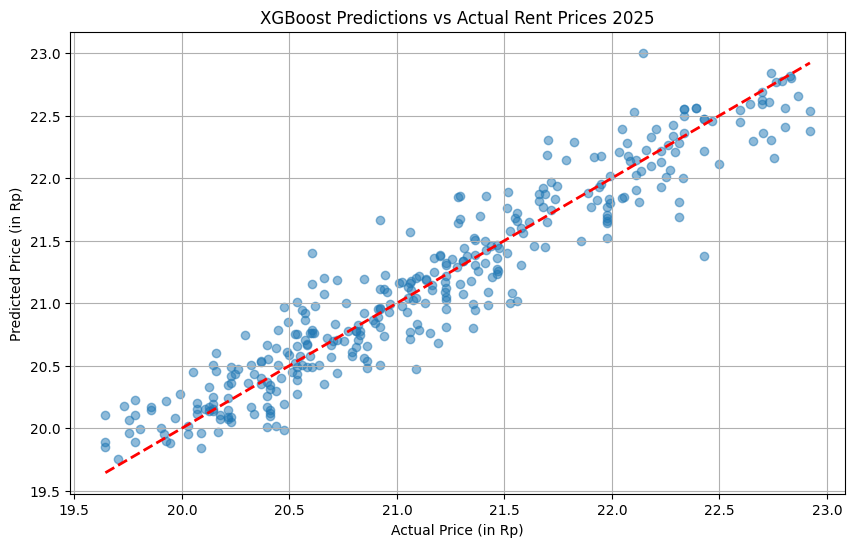

In [403]:
# visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_sale_test, sale_2025_pred, alpha=0.5)
plt.plot([y_sale_test.min(), y_sale_test.max()], [y_sale_test.min(), y_sale_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual Rent Prices 2025')
plt.grid()
plt.show()

## INFERENCE: 2025 Property Sale Investment Features Integration 

In [423]:
# Add Property Sale Investment Features
df_sale_2025 = df_sale.copy()

# Market price for 2025 dataset
df_sale_2025['market_price_2025'] = np.expm1(sale_2025_model.predict(X_sale_to_sale_2025.to_numpy()))

# 2023 price for 2025 dataset
df_sale_2025['market_price_2023'] = np.expm1(sale_2023_model.predict(X_sale_to_sale_2023.to_numpy()))

# 2025 rent for 2025 dataset
df_sale_2025['rent_price_per_year_2025'] = np.expm1(rent_2025_model.predict(X_rent_to_sale_2025.to_numpy()))

In [424]:
# assume 30% expense ratio
OPERATING_EXPENSE_RATIO = 0.30
df_sale_2025['NOI'] = df_sale_2025['rent_price_per_year_2025'] * (1 - OPERATING_EXPENSE_RATIO)
# calculate cap rate
df_sale_2025['cap_rate'] = df_sale_2025['NOI'] / df_sale_2025['price_in_rp'] * 100
# average cap rate
avg = df_sale_2025['cap_rate'].mean()
print(f"Average cap rate (assuming 30% OER): {avg:.2f}%")

Average cap rate (assuming 30% OER): 3.12%


In [425]:
# --- Calculate the Compound Annual Growth Rate (CAGR) ---

# Define the number of years between the two price points
num_years = 2025 - 2023

# Calculate the property value growth rate (CAGR)
# Adding a small number (epsilon) to the denominator to avoid division by zero errors
epsilon = 1e-9
df_sale_2025['property_value_growth'] = \
    ((df_sale_2025['market_price_2025'] / (df_sale_2025['market_price_2023'] + epsilon)) ** (1/num_years)) - 1

# Display the first few rows with the new column
print(df_sale_2025[['market_price_2023', 'price_in_rp', 'property_value_growth']].head())

   market_price_2023   price_in_rp  property_value_growth
0       7.896788e+08  5.900000e+08              -0.076203
1       1.324457e+09  2.040000e+09               0.112790
2       3.577889e+08  3.400000e+08              -0.002653
3       5.324677e+08  8.400000e+08               0.251855
4       2.184640e+09  2.770000e+09               0.115052


In [426]:
# --- Assumptions ---
discount_rate = 0.10
holding_period_years = 10
rent_growth_rate = 0.03
operating_expense_ratio = 0.30

# --- NPV Calculation using the new dynamic growth rate ---

# Year 1 NOI
noi_year_1 = df_sale_2025['rent_price_per_year_2025'] * (1 - operating_expense_ratio)

# Year 2 NOI
noi_year_2 = noi_year_1 * (1 + rent_growth_rate)

# Estimated Future Sale Price (Terminal Value)
# Using the calculated 'property_value_growth' for each property
# Projecting from the most recent price, 'price_in_rp'
future_sale_price = df_sale_2025['price_in_rp'] * \
    (1 + df_sale_2025['property_value_growth']) ** holding_period_years

# Calculate Present Value of all cash flows
pv_noi_year_1 = noi_year_1 / (1 + discount_rate) ** 1
pv_noi_year_2 = noi_year_2 / (1 + discount_rate) ** 2
pv_future_sale_price = future_sale_price / (1 + discount_rate) ** holding_period_years

# Calculate Final NPV
# Assuming 'price_in_rp' is the acquisition cost in 2025
df_sale_2025['NPV'] = pv_noi_year_1 + pv_noi_year_2 + pv_future_sale_price - df_sale_2025['price_in_rp']

In [427]:
df_sale_2025.sort_values('NPV', ascending=False).head(5)

,url,title,price_in_rp,district,city,bedrooms,bathrooms,land_size_m2,building_size_m2,certificate,electricity_power,property_condition,floor_count,description,market_price_2025,market_price_2023,rent_price_per_year_2025,NOI,cap_rate,property_value_growth,NPV
1398,https://www.rumah123.com/properti/jakarta-utar...,"Jual Cepat, Rumah 2,5Lt Rapih Siap Huni Di Sun...",2.750000e+09,Sunter,Jakarta Utara,3.0,2.0,108.0,1.0,SHM,0.0,Bagus,2.0,"(Ir EG) Jual Cepat, Rumah 2,5Lt Rapih Siap Hun...",2.670868e+09,6.314798e+08,78627272.0,55039088.0,2.001421,1.056584,1.432409e+12
9,https://www.rumah123.com/properti/depok/hos177...,Rumah 2 Lantai Semi Furnished Siap Huni Lingku...,9.000000e+09,Cinere,Depok,5.0,4.0,420.0,600.0,SHM,7700.0,Bagus,2.0,*SPESIFIKASI TAMBAHAN*\n1. Lantai bawah terdir...,8.908627e+09,3.631518e+09,234379328.0,164065520.0,1.822950,0.566251,2.995570e+11
507,https://www.rumah123.com/properti/bogor/hos394...,Sv. Dijual Cepat Rumah 2lt Rapih Kota Wisata S...,1.700000e+09,Kota Wisata,Bogor,3.0,2.0,128.0,1.0,SHM,0.0,Bagus,2.0,Luas tanah 128m2\nKmr tdr 3\nKmr mandi2\nAC 4\...,1.727530e+09,5.246787e+08,59801532.0,41861072.0,2.462416,0.814538,2.519933e+11
1315,https://www.rumah123.com/properti/jakarta-sela...,Termurah Hitung Tanah Bonus Rumah Di Pondok Indah,5.500000e+09,Pondok Indah,Jakarta Selatan,2.0,2.0,184.0,100.0,SHM,3300.0,Butuh Renovasi,1.0,Termurah Hitung Tanah Bonus Rumah Di Pondok In...,5.494835e+09,2.188619e+09,102967944.0,72077560.0,1.310501,0.584500,2.061503e+11
1357,https://www.rumah123.com/properti/jakarta-sela...,Dijual Rumah Murah di Pinang Nikel Pondok Inda...,8.750000e+09,Pondok Indah,Jakarta Selatan,5.0,4.0,241.0,300.0,SHM,0.0,Bagus,2.0,JUAL CEPAT! MURAH!\n\nRumah dijual di Pondok I...,8.781324e+09,3.869707e+09,240216336.0,168151440.0,1.921731,0.506402,1.945435e+11


In [428]:
df_sale_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       1739 non-null   object 
 1   title                     1739 non-null   object 
 2   price_in_rp               1739 non-null   float64
 3   district                  1739 non-null   object 
 4   city                      1739 non-null   object 
 5   bedrooms                  1739 non-null   float64
 6   bathrooms                 1739 non-null   float64
 7   land_size_m2              1739 non-null   float64
 8   building_size_m2          1739 non-null   float64
 9   certificate               1739 non-null   object 
 10  electricity_power         1739 non-null   float64
 11  property_condition        1739 non-null   object 
 12  floor_count               1739 non-null   float64
 13  description               1739 non-null   object 
 14  market_p

In [429]:
df_sale_2025.sort_values(by='NPV', ascending=False).loc[:, 'district'].head(20)

1398                Sunter
9                   Cinere
507            Kota Wisata
1315          Pondok Indah
1357          Pondok Indah
1426          Pondok Indah
208                 Cinere
28      Pantai Indah Kapuk
1260          Pondok Indah
1105                Tomang
774           Pondok Indah
795           Pondok Indah
743                 Kemang
851                  Tebet
664                 Kemang
809          Cempaka Putih
1184    Pantai Indah Kapuk
436           Pondok Indah
1408          Pondok Indah
1359            Kemandoran
Name: district, dtype: object

In [430]:
def format_rupiah(price_rp):
    """
    Converts a large Rupiah value into a more readable string format
    (e.g., "1 Miliar", "100 Juta").
    """
    if pd.isna(price_rp):
        return np.nan # Handle NaN values if any

    price = int(price_rp) # Convert to int for easier comparison

    if price >= 1_000_000_000_000:
        return f"{price / 1_000_000_000_000:.0f} Triliun"
    elif price >= 1_000_000_000:
        return f"{price / 1_000_000_000:.0f} Miliar"
    elif price >= 1_000_000:
        return f"{price / 1_000_000:.0f} Juta"
    elif price >= 1_000:
        return f"{price / 1_000:.0f} Ribu"
    else:
        return str(price)

# See the number of listings per district
print("Listings per district:")
print(df_sale_2025['district'].value_counts())

# Get a statistical summary of prices for each district,
# and then apply the formatting for display
print("\nPrice summary by district (formatted for display):")

# Calculate the descriptive statistics first
price_summary = df_sale_2025.sort_values('NPV', ascending=False).groupby('district')['price_in_rp'].describe().round(2)

# Create a copy to apply string formatting for display
price_summary_display = price_summary.copy()

# Apply the formatting function to relevant columns for display
for col in ['mean', 'min', 'max', '25%', '50%', '75%']:
    if col in price_summary_display.columns:
        price_summary_display[col] = price_summary_display[col].apply(format_rupiah)

print(price_summary_display)

Listings per district:
district
BSD                                 146
BSD City                             98
Gading Serpong                       87
Kelapa Gading                        63
Cibubur                              63
Cakung                               47
Sunter                               47
Pantai Indah Kapuk                   44
Cipayung                             37
Kota Wisata                          35
Harapan Indah                        33
Alam Sutera                          33
Summarecon Bekasi                    33
Sentul City                          31
Cibinong                             30
Jagakarsa                            29
Cinere                               28
Pantai Indah Kapuk 2                 27
Green Lake City                      26
Jati Asih                            25
Pancoran Mas                         25
Bojong Gede                          25
Bogor Barat                          24
Bekasi Utara                         23
Sawangan

In [431]:
# See the number of listings per city (WITHOUT FORMATTING)

print("Listings per city:")
print(df_sale_2025['city'].value_counts())

# Get a statistical summary of prices for each city
print("\nPrice summary by city (in Billion Rp):")
print((df_sale_2025.groupby('city')['price_in_rp']).describe().round(2))

Listings per city:
city
Tangerang          437
Bogor              234
Depok              225
Bekasi             193
Jakarta Timur      192
Jakarta Utara      191
Jakarta Barat      136
Jakarta Selatan    110
Jakarta Pusat       21
Name: count, dtype: int64

Price summary by city (in Billion Rp):
                 count          mean           std          min           25%  \
city                                                                            
Bekasi           193.0  1.031974e+09  7.863123e+08  330000000.0  6.000000e+08   
Bogor            234.0  1.186120e+09  1.069261e+09  325000000.0  5.900000e+08   
Depok            225.0  1.247996e+09  1.063387e+09  340000000.0  7.200000e+08   
Jakarta Barat    136.0  3.174412e+09  1.829216e+09  670000000.0  1.872500e+09   
Jakarta Pusat     21.0  1.576048e+09  1.433864e+09  403000000.0  7.380000e+08   
Jakarta Selatan  110.0  4.235518e+09  2.525789e+09  740000000.0  1.870000e+09   
Jakarta Timur    192.0  1.580141e+09  1.116118e+09  360

In [432]:
# Top 15 districts by average NPV
print("Top districts by average NPV:")
print(df_sale_2025.groupby('district')['NPV'].mean().sort_values(ascending=False).head(15))

# Top 15 districts by average historical property growth
print("\nTop districts by average property value growth:")
print(df_sale_2025.groupby('district')['property_value_growth'].mean().sort_values(ascending=False).head(15))

Top districts by average NPV:
district
Pondok Indah        7.948932e+10
Kemandoran          6.440880e+10
Kebayoran Lama      5.982447e+10
Menteng             5.887189e+10
Mampang             4.375851e+10
Tomang              3.937924e+10
Kemang              2.964044e+10
Sunter              2.799688e+10
Kebayoran Baru      2.753191e+10
Tebet               2.360035e+10
Summarecon Bogor    2.018145e+10
Cinere              1.848792e+10
Permata Buana       1.660456e+10
Bekasi Barat        1.581653e+10
Cipete              1.299410e+10
Name: NPV, dtype: float64

Top districts by average property value growth:
district
Menteng             0.499906
Kemandoran          0.388867
Kebayoran Lama      0.379751
Pondok Indah        0.372107
Senen               0.345657
Kebayoran Baru      0.322061
Mampang             0.315675
Tomang              0.297308
Bekasi Barat        0.230698
Cipete              0.229055
Tebet               0.226222
Kemang              0.223818
Pulomas             0.223411
Summa

In [433]:
# Calculate price per square meter
df_sale_2025['price_per_m2'] = df_sale_2025['price_in_rp'] / df_sale_2025['building_size_m2']

# Compare average price per m2 across districts
print("Districts with the lowest average price per square meter:")
print(df_sale_2025.groupby('district')['price_per_m2'].mean().sort_values().head(15))

Districts with the lowest average price per square meter:
district
Rawa Badak           2.578947e+06
Jonggol              7.350000e+06
Legenda Wisata       7.600000e+06
Bekasi Kota          8.015882e+06
BSD Residence One    8.771429e+06
Tenjo                9.027778e+06
Karang Tengah        9.333333e+06
Legok                9.444444e+06
Cilebut              9.675926e+06
Pesanggrahan         9.722222e+06
Pondok Cabe          9.900990e+06
Citayam              1.011823e+07
Cikarang             1.026667e+07
Tanah Baru           1.041667e+07
Tajur                1.045455e+07
Name: price_per_m2, dtype: float64


In [434]:
df_sale_2025.to_csv('rumah123_2025_sale_modelled.csv', index=True)